# OCR - How to remove frames from fields on a form

This article provides a simple but effective method for removing form field frames to be OCRed using [Tesseract-OCR](https://tesseract-ocr.github.io).
I will use Python and a [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) module to process signals.

| orignal | after frame removal |
|:---|:---|
|<img src="images/agnieszka_oryg.png" alt="pole z ramką" width="300">|<img src="images/agnieszka_bezram.png" alt="pole bez ramki" width="300">|
|<img src="images/lucyna_oryg.png" alt="pole z ramką" width="300">|<img src="images/lucyna_bezram.png" alt="pole bez ramki" width="300">|
|<img src="images/radoslaw_oryg.png" alt="pole z ramką" width="180">|<img src="images/radoslaw_bezram.png" alt="pole bez ramki" width="180">|
|<img src="images/pesel_oryg.png" alt="pesel z ramką" width="200">|<img src="images/pesel_bezram.png" alt="pesel bez ramki" width="200">|

## Need

There was a need for automatic reading of forms received as scans. Forms are filled using computer. Then they are printed, signed and scanned. The scanned form goes to a program whose task is to read all the fields and enter them into the database. Printers and scanners are different, so the received forms may have different quality, resolution, and form position (e.g., the form may be rotated or shifted).  
**These forms and are not specially designed for OCR processing.** They don't have any special tags, barcodes or a special fonts.  
In a separate article I will describe the process of recognizing form pages and extracting individual fields. Here we will prepare the image of **a single field for OCR processing**.
OCR works effectively when the image contains only the text that you want to read. Additional elements interfere with its operation and can be interpreted by OCR as random text.

Let's go!  

The first image shows what we get as input. Second - what we strive for

<img src="images/lucyna_przed_po.png" alt="efekt usuwania ramek">

## Idea

As you can see in the input image, the frames are the longest rows of pixels.
The idea is to remove them by treating the image as a regular two-dimensional matrix and then **summing the pixel values along the x and y axes**. Then we will **identify the highest values of these sums**. The frame is where the most pixels are.

# Implementation

### Negative

Before we start adding pixels, we will create a negative image. This will facilitate processing. The pixels of interest, i.e. the text and the frame, will get high values (close to 255). On the other hand, the background will be close to zero.

In [1]:
from PIL import Image
import numpy as np

img = Image.open('images/lucyna_oryg.png').convert('L')

# negative
img_arr = np.array(img)
img_inv = 255 - img_arr

We have the original image in the ```img_arr``` matrix. The negative image is in the ```img_inv``` variable.  
Negative image:

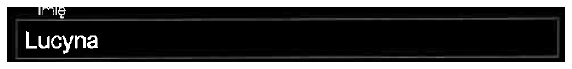

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,2))
_ = ax.imshow(img_inv, cmap='gray', interpolation='nearest')
_ = ax.axis('off')

Now we sum the pixel values along each axis.

In [3]:
rows_sum = np.sum(img_inv, axis=1)
cols_sum = np.sum(img_inv, axis=0)

Let's see what these sums look like on the x and y axes.

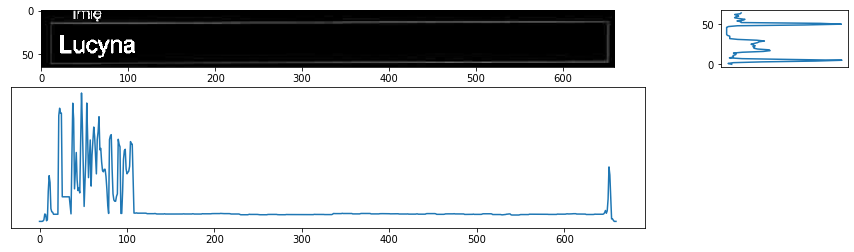

In [4]:
fig = plt.figure(figsize=(15,4))
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[10,2], height_ratios=[2,5])

ax = fig.add_subplot(spec[0,0])
ax.imshow(img_inv, cmap='gray', interpolation='nearest')

ax = fig.add_subplot(spec[0,1])
ax.plot(rows_sum[::-1], range(len(rows_sum)))
ax.set_xticks([])

ax = fig.add_subplot(spec[1,0])
ax.plot(cols_sum)
ax.set_yticks([])

plt.show()

Let's look at the graph of the totals along the x-axis (below the box image). Single peaks appeared at the beginning and end that identify the frame. Unfortunately, they are not very clear. They are lower than the peaks derived from letters. The letters are "thicker" and whiter. They have higher pixel values than the frame. We'll deal with in a moment.
Now let's look at the sum graph along the y-axis (right). The frame is much longer than the text in the field, so the frame peaks are more noticeable. If we know the position of these peaks, we will know the position of the frame on the y axis.  
But before we do that, we will improve the image a bit to make the frames more visible.

### Binarization

We binarize the image. This is a necessary step, because as we can see the frame in the picture is gray, and we want it to be clear and easy to find through the mechanisms that we will apply in a moment.

For this purpose, we use [thresholding](https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html) from the OpenCV library. We set the binarization level quite low (20). We want even a fairly dark frame to be clearly visible.  
By "dark" I mean the negative frame that we are working on. In the original image it corresponds to a very light frame.

In [5]:
import cv2
(thresh, img_bin) = cv2.threshold(img_inv, 20, 255, cv2.THRESH_BINARY)

Below is the binarization effect:

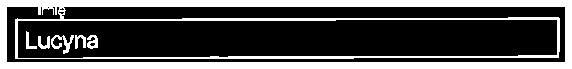

In [6]:
fig, ax = plt.subplots(figsize=(10,2))
_ = ax.imshow(img_bin, cmap='gray', interpolation='nearest')
_ = ax.axis('off')

You are probably asking yourself why I didn't set the binarization threshold in such a way as to remove the frame from the image immediately. It would be enough to raise the binarization threshold a bit and the frame will disappear.   
Well, there are several reasons why I didn't:
* Forms are printed on different printers and scanned on different scanners. Often without shades of gray - already binarized. In this case, the frame has the same brightness as the text. Setting the binarization to a high level would make the text disappear. Additionally, a dedicated binarization level should be set for each image. OpenCV does this, but as I mentioned before, for an image that is already binarized by a scanner or printer, it either removes all content or fails to remove the frame.
* Determining the binarization level may causes the frame to disappear. Sometimes turns out that the gray transitions around the letters are also lost. This causes their "erosion" which Tesseract is less able to deal with. In extreme cases, the letter "O" may turn into "C" or "U" or the Polish "tails" may disappear.
* Removing the frame itself from this image will leave some remnants of „Imię”, which is the description of the field. Tesseract can't handle it. As a result of OCR, in addition to the main content, we will get additional, undesirable elements. Later you will see that for this reason I am not only deleting the frame but all the content around it.

Therefore, I decided that it is better to find the position of the frame and remove it than to rely solely on the binarization effects.

### Bold text

Sometimes there are gaps in the frame image due to imperfections in the printer or scanner.
They would disturb further processing. That's why I use the OpenCV [dilate](https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html) function.  
This is the opposite of erosion. The function "fills in" holes in the pixel continuity and simultaneously thickens all elements in the image. Including the frame we care about the most. We want it to be perfectly visible.

In [7]:
img_bin = cv2.dilate(img_bin, (3, 3), iterations=2)

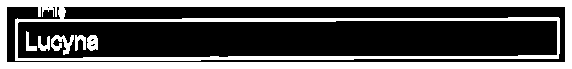

In [8]:
fig, ax = plt.subplots(figsize=(10,2))
_ = ax.imshow(img_bin, cmap='gray', interpolation='nearest')
_ = ax.axis('off')

In this way, we achieve a picture that is satisfactory from the point of view of further actions. The letters have become difficult to read, but the frame is very clear.

Before we move on to removing frames, let's look again at the graphs of pixel sums along both axes.

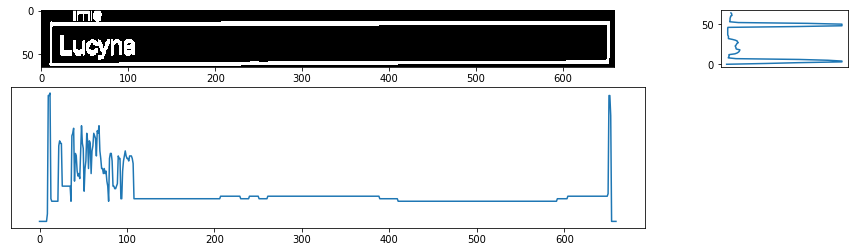

In [9]:
rows_sum = np.sum(img_bin, axis=1)
cols_sum = np.sum(img_bin, axis=0)

fig = plt.figure(figsize=(15,4))
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[10,2], height_ratios=[2,5])

ax = fig.add_subplot(spec[0,0])
ax.imshow(img_bin, cmap='gray', interpolation='nearest')

ax = fig.add_subplot(spec[0,1])
ax.plot(rows_sum[::-1], range(len(rows_sum)))
ax.set_xticks([])

ax = fig.add_subplot(spec[1,0])
ax.plot(cols_sum)
ax.set_yticks([])

plt.show()

We see a significant improvement. Two very distinct frame peaks appear in the graph along the x-axis (below the field image) that dominate the letter-derived peaks.
The situation in the sum plot along the y-axis (right) is even better. The letter-related peaks are practically gone. The frame peaks dominate!  

The whole difficulty is finding the peaks in these plots.

### Frames removal

Let's start by removing the horizontal parts of the frames (look at the graph on the right).  
The choice of horizontal lines is not accidental:

1. As you can see in the graph on the right, the frame peaks are the most pronounced because they are the longest series of bright pixels. Even if there were a lot of letters inside the frame (e.g. a very long name), the frame is the longest sequence of pixels anyway.
2. Finding horizontal frames will also allow us to remove the unwanted word „Imię” ("Name").
3. Bonus - after removing the horizontal frames and the word „Imię”, **the vertical frames will become even clearer**.  

Note that if in the field instead of the name "Lucyna" there was a text like "L**I**cyna" (capital letter "I" instead of "u") then the sum along the y axis in place of this replaced letter could be higher than the sum resulting from the frame length. The pixels from the letter "I" for "Imię" and from the letter "I" for "L**I**cyna" would be summed up. A search for the highest peak (frame) would indicate this place. We would cut off the useful letters "LI" and the result would be the word "cyna".  
It is very good that we first cut off the horizontal parts of the frame and everything outside the field.

In the first step of removing horizontal parts of frames, we determine "horizontal" pixel sums, that is, sums relative to the x-axis. In other words, row totals.

In [10]:
rows_sum = np.sum(img_bin, axis=1)

I use the [find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html#scipy.signal.find_peaks) function from the signal module of the scipy package to find the peaks.  
The function finds all (not just the highest peaks) as shown in the example below.

In [11]:
import scipy.signal
scipy.signal.find_peaks(rows_sum)

(array([ 3, 15, 37, 46, 60], dtype=int64), {})

The peaks from the frame are those at positions 15 and 60. The other values are local peaks for the letters.  
The parameter that allows you to specify the minimum distance between peaks comes in handy.  
I know that in our case, the distance between the top and bottom frames cannot be less than 60% of the image height. So I add this parameter to find_peaks.

In [12]:
img_height = len(rows_sum)
pky, _ = scipy.signal.find_peaks(rows_sum, distance=img_height * 0.6)
y0, y1 = pky[0], pky[1]
print(y0, y1)

15 60


Great! We have the location of the top and bottom of the frame. We can remove the horizontal frames and everything above and below the frames.  
To make sure that I remove the entire frame and not just half of it, I add 4 pixels.

In [13]:
px = 4 
# tworzę macierz z samych zer o wielkości pierwotnego obrazu
mask_up_down = np.zeros(img_arr.shape, dtype=np.uint8)
# tylko piksele oznaczone jedynką w masce pozostaną na obrazie. Pozostałe zostaną zastąpione zerem.
mask_up_down[y0 + px:y1 - px, :] = 1
img_bin = np.where(mask_up_down == 1, img_bin, 0)

Here is the effect of removing the top and bottom frames and the field description ("Imię").

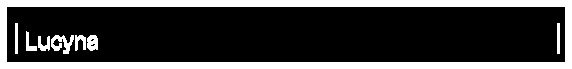

In [14]:
fig, ax = plt.subplots(figsize=(10,2))
_ = ax.imshow(img_bin, cmap='gray', interpolation='nearest')
_ = ax.axis('off')
plt.show()

Super! Unnecessary elements have disappeared from the image as expected.  
If we were to pass this result into a Tesseract, we would probably get "ILucyna I" or "ILucyna l" (extra capital letters "i" or lowercase "L"). We need to remove the vertical parts of the frame.  
Let's check the pixel distribution along the x axis.

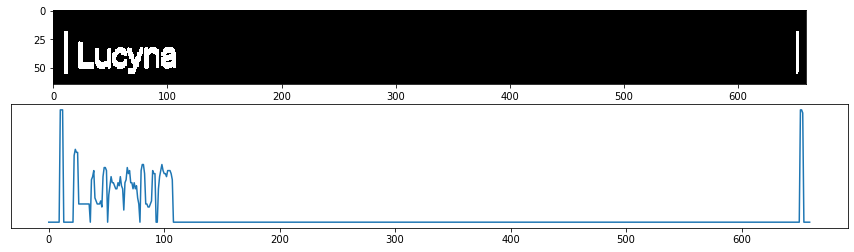

In [15]:
cols_sum = np.sum(img_bin, axis=0)
fig = plt.figure(figsize=(15,4))
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[3,5])

ax = fig.add_subplot(spec[0,0])
ax.imshow(img_bin, cmap='gray', interpolation='nearest')

ax = fig.add_subplot(spec[1,0])
ax.plot(cols_sum)
ax.set_yticks([])

plt.show()

It looks great. You can clearly see the highest peaks coming from the frames. Lower peaks show letters. The letter "L" generates a fairly tall peak (second from left), but it does not threaten the frame peak.  
We can start searching for peaks.  
First, find_peaks with no additional parameters.

In [16]:
pkx, _ = scipy.signal.find_peaks(cols_sum)
print(pkx)

[ 11  23  39  45  48  54  60  62  68  70  74  76  81  90  98 104 651]


The function finds all peaks. In fact, you could only take the first and last, because in this case they are what mark the frame. Experience shows, however, that this is not always the case. Sometimes there are noises in the image outside the box that the first and last peak picking mechanism would consider as a frame.  
To be sure, we will use the distance parameter. I know that text inside a frame never covers more than 70% of the width of the image.  
In addition, I assume that the highest peaks must be within 90% -100% of the maximum peak height, i.e. one of the highest peaks may be at least 90% of the height of the highest peak.

In [17]:
max_height = np.max(cols_sum)
pkx, _ = scipy.signal.find_peaks(cols_sum, distance=len(cols_sum) * 0.7, height=max_height * 0.9)
x0, x1 = pkx[0], pkx[1]
print(x0, x1)

11 651


Thus, we found the positions of the frame boundaries on the x axis.

We have all the coordinates we need - you can start deleting the frame.  
We will remove it on the original image. We will create a mask that we will put on the original image. Only those pixels where 1 is set in the mask will be selected for the final image. The rest of the image will be replaced with 255 (white color).  
We will subtract 4 pixels from each side of the mask. This will make the mask a bit smaller than the frame and make sure that the entire frame is removed from the image.

In [18]:
px = 4
mask = np.zeros(img_arr.shape, dtype=np.uint8)
mask[y0 + px : y1 - px, x0 + px : x1 - px] = 1
img_masked = np.where(mask == 1, img_arr, 255)

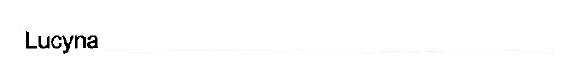

In [19]:
fig, ax = plt.subplots(figsize=(10,2))
_ = ax.imshow(img_masked, cmap='gray', interpolation='nearest')
_ = ax.axis('off')
plt.show()

Congratulations!!!  

The effect is 100% as expected! All disruptions have been removed.  
Now Tesseract can read the field without any problems.

### Numeric fields with separators (PESEL, KRS, NIP, REGON, etc.)

<img src="images/pesel_oryg.png" alt="pole z ramką" width="250">

The form fields for entering numbers usually consist of small blocks for one number each. The point is that the digits are clearly separated and the person completing the form could easily verify that he entered the correct number of digits (e.g. 11 digits for the PESEL number).  

Removing only the outer frame as shown above is not sufficient for OCR mechanisms. After removing the frame, there will be some leftover digit separators, which OCR will read as a comma, the letter "i", a lowercase "L". Or at worst, a number "one".  
Why is “one” the worst case? Non-numeric characters can be treated as errors and can be easily removed after being read by OCR. On the other hand, “one” can appear both as unwanted noise, but also as a number that we are interested in.


Let's carry out the frame removal on an example PESEL field.  
To begin with, we will repeat the same actions that we did by removing the box from the "Imię" field.

In [20]:
# wczytujemy obraz do obróbki
img = Image.open("images/pesel_oryg.png").convert('L')

# negatyw
img_arr = np.array(img)
img_inv = 255 - img_arr

# binarization and thresholding
(thresh, img_bin) = cv2.threshold(img_inv, 20, 255, cv2.THRESH_BINARY)

# dilate
img_bin = cv2.dilate(img_bin, (3, 3), iterations=2)

# top and bottom frame part removal
rows_sum = np.sum(img_bin, axis=1)
img_height = len(rows_sum)
pky, _ = scipy.signal.find_peaks(rows_sum, distance=img_height * 0.6)
y0, y1 = pky[0], pky[1]

px = 4 
mask_up_down = np.zeros(img_arr.shape, dtype=np.uint8)
mask_up_down[y0 + px:y1 - px, :] = 1
img_bin = np.where(mask_up_down == 1, img_bin, 0)

# left and right frame part removal
cols_sum = np.sum(img_bin, axis=0)
max_height = np.max(cols_sum)
pkx, _ = scipy.signal.find_peaks(cols_sum, distance=len(cols_sum) * 0.7, height=max_height * 0.9)
x0, x1 = pkx[0], pkx[1]

px = 4
mask = np.zeros(img_arr.shape, dtype=np.uint8)
mask[y0 + px : y1 - px, x0 + px : x1 - px] = 1

img_masked = np.where(mask == 1, img_arr, 255)

> Warning! This is not a complete solution. Note that the peak search may return no value or return more than two peaks. In a commercial solution, this situation must be properly handled.

This is what the mask looks like:

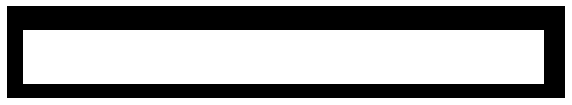

In [21]:
fig, ax = plt.subplots(figsize=(10,2))
_ = ax.imshow(mask, cmap='gray', interpolation='nearest')
_ = ax.axis('off')
plt.show()

The black part will be removed from the image. Only white rectangle inside will remain.

This is the result:

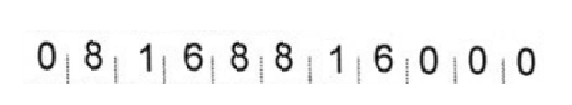

In [22]:
fig, ax = plt.subplots(figsize=(10,2))
_ = ax.imshow(img_masked, cmap='gray', interpolation='nearest')
_ = ax.axis('off')
plt.show()

Note that:

* separators are at equal distances from each other,
* the distance between the first separator and the left frame is the same as the distance between the separators,
* the numbers are at a safe distance from the separators,
* we have information about the coordinates of the outer frame (variables ```x0```, ```x1```, ```y0```, ```y1```)

It is clearly shown in the figure below.

<img src="images/pesel_podzial.png" alt="pesel-podzielony" width="600">

What you need to do is remove the separators that are at equal distances from each other.  
We determine the length of the field (as the difference between ```x1``` and ```x0```) and determine the number of characters in the field (```11``` here). Dividing the length by the number of digits gives us the distance between the separators.  
In the next step, we set the mask at equal distances from the left part of the frame, i.e. from the point ```x0```.  
Traditionally, we remove 4 pixels to the right and left of the designated point to be sure to remove the entire separator. The digits are at a safe distance from the separators so they will not be damaged.  
This is the code for this action:

In [23]:
px = 4
field_length = x1 - x0
number_of_digits = 11  # PESEL
peak_dist = field_length / number_of_digits
for peak_number in range(1, number_of_digits):
    x_pos = x0 + int(peak_number * peak_dist)
    mask[:, x_pos - px:x_pos + px] = 0

img_masked = np.where(mask == 1, img_arr, 255)

Notice that we are operating on a mask that already covers the frame. Here we only add masking for separators.  
The mask looks like this:

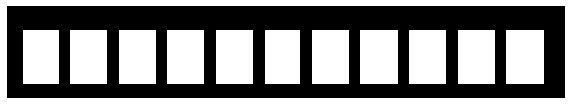

In [24]:
fig, ax = plt.subplots(figsize=(10,2))
_ = ax.imshow(mask, cmap='gray', interpolation='nearest')
_ = ax.axis('off')
plt.show()

Here is the result:

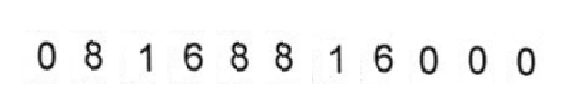

In [25]:
fig, ax = plt.subplots(figsize=(10,2))
_ = ax.imshow(img_masked, cmap='gray', interpolation='nearest')
_ = ax.axis('off')
plt.show()

Great!!!  

All separators have been removed.  
Such an image can be sent to the OCR.

## Summary

As the input, we received an image of a field cut from a larger form. The field, apart from the text, contained redundant elements: a frame and a field name. Using the [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) library we removed redundant elements. We obtained an image containing only the text we required.  

Initially, I was wondering how to remove the frame by making it as invisible as possible. I used various binarization techniques, automatically selecting the cut-off level. I tried to change the appearance of the form in such a way that the frames did not appear on the scan. However, the effects were not satisfactory.  

Eventually it turned out that "the frame is not your enemy but your friend". The clearer the frame, the easier it can be found and removed. For this reason, in the next version of the form, the frames will be slightly darker and thicker so that they will not disappear during printing and scanning.

In the following articles, I plan to describe how to deal with:  
- recognizing the page and form type,
- cutting individual fields from the form,
- recognizing whether a checkbox has been selected on the form (using machine learning and the [Keras](https://keras.io/) library) <img src="images/checkboxes.png" alt="checkboxy" width="400">.

You can find Jupyter Notebook version of this article in this repository: https://github.com/klosow/ocr-forms

You can find me on LinkedIn - Krzysztof Kłosowski https://www.linkedin.com/in/klosowski/